In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
import re
from datasets import Dataset

# Function to clean the text
def clean_text(text):                                     #creates the clean text function
    text = re.sub(r'[^\u0C00-\u0C7F\s.,!?]', '', text)    #removes the special characters from the text
    text = re.sub(r'\s+', ' ', text).strip()  # removes white spaces from  the text
    return text    # returns the clean text

# Loads the datasets
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/telugu_train.csv")   #Loads the training dataset(18000 samples) 60%
val_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/telugu_val.csv")       #loads the validation dataset(6000 samples)20%
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/telugu_test.csv")     #loads the testing dataset(6000 samples )  20%
                                                                                    # 0 Toxic
# Apply cleaning                                                                    # 1 Non-Toxic
train_df['text'] = train_df['text'].apply(clean_text)  #changes initial training dataset to cleaned trained dataset
val_df['text'] = val_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

# Load the tokenizer and model
model_name = "ai4bharat/indic-bert"    #AI model to deal with regional languages (BERT- Bidirectional Encoder Representations from Transformers )
tokenizer = AutoTokenizer.from_pretrained(model_name)  #tokenizes the text of regional language
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  #classifies the text into toxic and non toxic as we mentioned num_labels = 2

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)   #tokenizes the text in to equal lenghths of 128 and removing the tokens lenghth of more than 128

train_dataset = Dataset.from_pandas(train_df)  #converts pandas dataframe into hugging face dataframe by using Dataset.from_pandas
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)  # the training dataset id mapped with the new tokens for training
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])  # converts th specified column tokens in to tensor units
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])    #attention mask is used for considering the real token and ignoring the padding token
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,  # Increase epochs for better training
    per_device_train_batch_size=8, #uses the batch size of 8 for training (takes 8 rows from the dataset)
    per_device_eval_batch_size=8,
    warmup_steps=500,  #Gradually increases the learning rate over the first 500 steps to stabilize training.
    weight_decay=0.01, #:Applies L2 regularization to prevent overfitting.
    learning_rate=2e-5,  # Sets a small learning rate, typical for fine-tuning BERT models
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",  # Evaluates the model at the end of each epoch.
    save_strategy="epoch",  #Saves a model checkpoint at the end of each epoch.
    load_best_model_at_end=True,  #Loads the best-performing model (based on evaluation metrics) at the end of training
)
# Compute metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,       #: The IndicBERT model to be fine-tuned.
    args=training_args,  #The training configuration defined earlier.
    train_dataset=train_dataset, #The tokenized training dataset.
    eval_dataset=val_dataset,  #The tokenized validation dataset for evaluation during training.
    compute_metrics=compute_metrics,   #The function to compute evaluation metrics.
)

# Train the model
trainer.train()   #starts the training process

# Save the model
trainer.save_model("indic_bert_toxicity_classifier_corrected")
tokenizer.save_pretrained("indic_bert_toxicity_classifier_corrected")   #Saves the model

# Evaluate on the test set
results = trainer.evaluate(test_dataset)
print("\nTest Set Evaluation:")
print(results)

# Evaluate on the test set with detailed metrics
test_predictions = trainer.predict(test_dataset)
y_test_pred = test_predictions.predictions.argmax(-1)
print("\nTest Set Classification Report:")
print(classification_report(test_dataset['label'], y_test_pred, target_names=['Toxic (0)', 'Non-Toxic (1)']))
print("\nTest Set Confusion Matrix:")
print(confusion_matrix(test_dataset['label'], y_test_pred))

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thilakchandrapenchala (thilakchandrapenchala-bv-raju-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.338700,0.347490,0.851500,0.851624,0.823776,0.881420
2,0.274800,0.326862,0.856833,0.849589,0.863345,0.836263
3,0.507800,0.366617,0.868667,0.872698,0.821222,0.931058
4,0.393900,0.555625,0.870000,0.868510,0.849885,0.887970
5,0.123300,0.641047,0.866500,0.862678,0.858117,0.867287



Test Set Evaluation:
{'eval_loss': 0.34705114364624023, 'eval_accuracy': 0.8516666666666667, 'eval_f1': 0.8388265121332851, 'eval_precision': 0.8527245949926362, 'eval_recall': 0.8253741981468282, 'eval_runtime': 43.1648, 'eval_samples_per_second': 139.002, 'eval_steps_per_second': 17.375, 'epoch': 5.0}

Test Set Classification Report:


NameError: name 'classification_report' is not defined

Test Set Evaluation:
{'eval_loss': 0.34705114364624023, 'eval_accuracy': 0.8516666666666667, 'eval_f1': 0.8388265121332851, 'eval_precision': 0.8527245949926362, 'eval_recall': 0.8253741981468282, 'eval_runtime': 43.3481, 'eval_samples_per_second': 138.414, 'eval_steps_per_second': 17.302, 'epoch': 5.0}


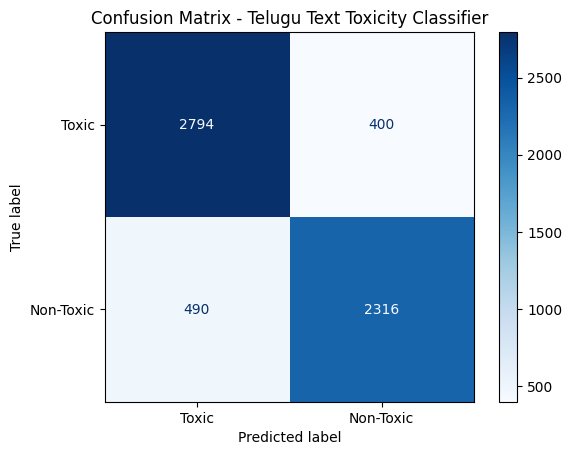

Confusion Matrix:
[[2794  400]
 [ 490 2316]]


In [ ]:
# Evaluate on the test set
results = trainer.evaluate(test_dataset)
print("Test Set Evaluation:")
print(results)

# Get test predictions
test_predictions = trainer.predict(test_dataset)
y_test_pred = test_predictions.predictions.argmax(-1)

# Compute and display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# True labels from test dataset
y_test_true = test_dataset['label']

# Compute confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred, labels=[0, 1])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Toxic', 'Non-Toxic'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Telugu Text Toxicity Classifier')
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)


#TP (2794) and TN (2316) are correct predictions; FP (490) and FN (400) are errors.

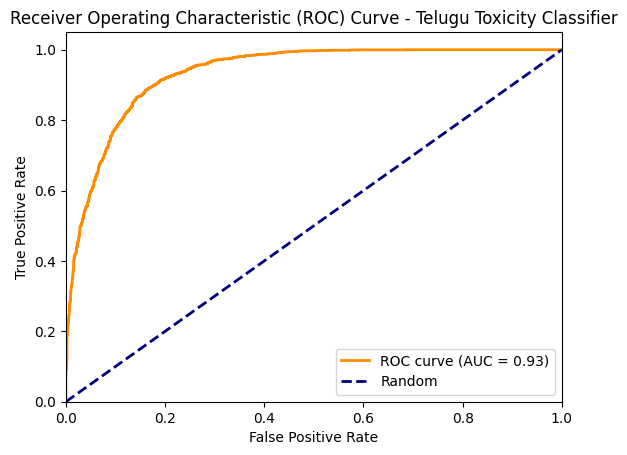

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get test predictions with probabilities
test_predictions = trainer.predict(test_dataset)
y_test_true = test_dataset['label']
y_test_prob = test_predictions.predictions[:, 1]  # Probability of non-toxic (class 1)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_true, y_test_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Telugu Toxicity Classifier')
plt.legend(loc="lower right")
plt.show()

#X-axis (False Positive Rate, FPR): The ratio of negative instances incorrectly classified as positive, calculated as FP / (FP + TN).
#Y-axis (True Positive Rate, TPR): The ratio of positive instances correctly classified as positive, calculated as TP / (TP + FN).

#Orange Curve (ROC Curve): The solid orange line represents the performance of your Telugu Toxicity Classifier.
#It starts near (0,0) and rises toward (1,1), indicating how TPR increases with FPR as the threshold changes.

#Blue Dashed Line (Random):
#The diagonal line from (0,0) to (1,1) represents the performance of a random classifier (e.g., flipping a coin).
# A model performing no better than random would follow this line.

#AUC = 0.93: The Area Under the ROC Curve (AUC) is a single scalar value summarizing the overall performance of the classifier.
#An AUC of 0.93 indicates excellent performance (closer to 1 is better).

#AUC = 0.93: This is an excellent score, indicating that there is a 93% chance that the model will rank a randomly chosen positive instance (toxic text)
#higher than a randomly chosen negative instance (non-toxic text).
#Range:
#0.5: Random guessing (no discriminative power).
#0.7–0.8: Acceptable.
#0.8–0.9: Good.
#0.9–1.0: Excellent.


In [ ]:
pip install gradio==5.23.0 deep-translator torch transformers opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Install deep-translator
!pip install deep-translator

# Import the library
from deep_translator import GoogleTranslator

# Initialize the translator
translator = GoogleTranslator()    #Google translator will convert our (Telugu+English) text to Telugu text

# Transliterate English to Telugu
english_text = "neeku antha seen ledu le"
telugu_text = translator.translate(english_text, source='en', target='te')
print(telugu_text)  # Output will be the translated Telugu text

Neeku Antha Seen Ledu Le


In [ ]:
 import gradio as gr  #Used for creating a frontebd
 import torch   #for converting a user input into tensor units
 from transformers import AutoTokenizer, AutoModelForSequenceClassification
 import re
 from deep_translator import GoogleTranslator

In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from deep_translator import GoogleTranslator
import re

# Load the trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/indic_bert_toxicity_classifier_corrected")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/indic_bert_toxicity_classifier_corrected")

# Initialize the translator
translator = GoogleTranslator(source='en', target='te')  #sets english as the input language and telugu as the output languae
#This will convert English-transliterated text (e.g., "neeku" for నీకు)
#into Telugu script, though accuracy depends on Google Translate’s capabilities.

# Function to clean the text
def clean_text(text):
    text = re.sub(r'[^\u0C00-\u0C7F\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to transliterate English to Telugu
def transliterate_to_telugu(text):
    if text and text.strip():  #Checks if the input is non-empty after stripping whitespace.
        try:
            return translator.translate(text)  #: Translate the English text to Telugu text
        except Exception:
            return "Translation failed: Check input or connection"
    return ""  #Returns translated text

# Function to predict toxicity
def predict_toxicity(english_text):
    # Step 1: Transliterate the input from English to Telugu
    telugu_text = transliterate_to_telugu(english_text)
    # Step 2: Clean the Telugu text
    cleaned_text = clean_text(telugu_text) if telugu_text and "failed" not in telugu_text else telugu_text
    # Step 3: Tokenize and predict using the transformer model
    if cleaned_text and "failed" not in cleaned_text:
        inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
        prob = torch.softmax(outputs.logits, dim=1)[0]
        confidence = max(prob).item() * 100
        # Step 4: Interpret the prediction (0 = Toxic, 1 = Non-Toxic)
        label = "Toxic" if prediction == 0 else "Non-Toxic"
        return f"Transliterated Telugu Text: {cleaned_text}\nPrediction: {label}\nConfidence: {confidence:.2f}%"
    return f"Transliterated Telugu Text: {cleaned_text}\nPrediction: No prediction (invalid input)"

# Gradio interface
with gr.Blocks(title="Telugu Text Toxicity Classifier (Transformer - Corrected with Transliteration)") as demo:
    gr.Markdown(
        """
        # Telugu Text Toxicity Classifier (Transformer - Corrected with Transliteration)
        Enter Telugu text in English transliteration (e.g., 'neeku' for నీకు). The app will convert it to Telugu script using Google Translate and predict if it's toxic or non-toxic. Note: Google Translate may not always transliterate accurately. If the output is incorrect, try adjusting your input (e.g., use 'scene' for సీన్).
        """
    )

    with gr.Row():
        with gr.Column():
            input_text = gr.Textbox(
                label="Enter Telugu Text (in English Transliterated Form)",
                placeholder="e.g., 'nuwvu chala manchodivi ra'",
                lines=2
            )
        with gr.Column():
            transliterated_text = gr.Textbox(
                label="Transliterated Telugu Text (Preview)",
                interactive=False,
                lines=2
            )

    with gr.Row():
        preview_button = gr.Button("Preview Transliteration")
        predict_button = gr.Button("Predict Toxicity")

    with gr.Row():
        output_text = gr.Textbox(
            label="Prediction",
            interactive=False,
            lines=5
        )

    # Connect buttons to functions
    preview_button.click(
        fn=transliterate_to_telugu,
        inputs=input_text,
        outputs=transliterated_text
    )
    predict_button.click(
        fn=predict_toxicity,
        inputs=input_text,
        outputs=output_text
    )

# Launch the interface
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5eae1959107a04c7a0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
